# Hypothesis testing validation

Power analysis for DM, DV, and DC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [4]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig3/'

### Simulate some data

1000 genes total, 100 are DE and 100 are DV

In [6]:
n_genes = 1000
n_cells = 10000

In [7]:
# Generate some gene characteristics for sample 1
mv_mean=[1, 2]
mv_cov=[[4, 0], [0, 0.4]]
params = stats.multivariate_normal.rvs(mean=mv_mean, cov=mv_cov, size=n_genes)
log_means_1, log_residual_variances_1 = params[:, 0], params[:, 1]

# Generate some gene characteristics for sample 2
# First 100 genes are DE, second 100 are DV
log_means_2 = log_means_1.copy()
log_means_2[:10] += 0
log_residual_variances_2 = log_residual_variances_1.copy()
log_residual_variances_2[10:20] += 2

true_data_1 = simulate.simulate_transcriptomes(n_cells, n_genes, log_means=log_means_1, log_res_var=log_residual_variances_1)
true_data_2 = simulate.simulate_transcriptomes(n_cells, n_genes, log_means=log_means_2, log_res_var=log_residual_variances_2)
true_data = np.vstack([true_data_1, true_data_2])

In [8]:
# Simulate the noise process
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)

In [9]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct_real'] = ['A' for i in range(n_cells)] + ['B' for i in range(n_cells)]
adata.obs['ct_shuffled'] = np.random.choice(['A', 'B'], adata.shape[0])
# adata.obs['ind'] = np.random.choice(list('aef'), adata.shape[0])

### HT on actual labels

In [10]:
adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct_real'], inplace=True)
scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=True, residual_var=True, use_n_umi=False, filter_mean_thresh=0.2, min_perc_group=.9)

In [11]:
%%time
imp.reload(hypothesis_test)
imp.reload(scmemo)
imp.reload(estimator)
imp.reload(bootstrap)
scmemo.ht_1d_moments(
	adata_scmemo, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	use_residual_var=True, 
	num_boot=50000, 
	dirichlet_approx=True,
    log=True,
    verbose=True)

On gene idx 0
On gene idx 300
CPU times: user 10min 26s, sys: 9min, total: 19min 27s
Wall time: 7min 42s


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


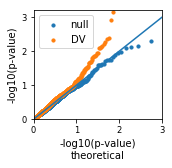

In [12]:
plt.figure(figsize=(2.3, 2))
plt.scatter(
    -np.log10(np.linspace(0, 1, adata_scmemo.uns['scmemo']['1d_ht']['mean_asl'].shape[0])), 
    -np.log10(np.sort(adata_scmemo.uns['scmemo']['1d_ht']['mean_asl'])), s=10, label='null')
plt.scatter(
    -np.log10(np.linspace(0, 1, adata_scmemo.uns['scmemo']['1d_ht']['var_asl'].shape[0])), 
    -np.log10(np.sort(adata_scmemo.uns['scmemo']['1d_ht']['var_asl'])), s=10, label='DV')
plt.plot([0, 4], [0, 4])
plt.xlim(0,3)
plt.ylim(0,3.2)
plt.legend()
plt.xlabel('-log10(p-value)\ntheoretical')
plt.ylabel('-log10(p-value)')
plt.savefig(fig_path + 'pvalue_qq_plot.pdf', bbox_inches='tight')

### WLS implementation

In [5]:
def _wlstsq(X, y, weights, cov_idx):
	""" 
		Perform weighted least squares and return the coefficients and the p-values. 
		
		Because the standard errors of the estimates are estimated with the bootstrap, we perform the Z-test, trusting these standard errors
		more than we normally would for OLS or WLS. 
	"""

	inv = np.linalg.inv(X.T.dot(weights.reshape(-1,1)*X))
	beta = inv.dot(X.T*weights).dot(y)
# 	stde = np.sqrt(np.diag(inv))
	
	return beta.reshape(-1)#, stde

In [46]:
def _simple_wlstsq(X, y, weights):

    
    X_mean = np.average(X, axis=0, weights=weights).reshape(-1, 1)
    y_mean = np.average(y, axis=0, weights=weights).reshape(-1, 1)
        
    X_centered = X - X_mean
    
    beta = ((weights*X_centered)*(y-y_mean)).sum(axis=0)/(weights*X_centered**2).sum(axis=0)
    
    return beta

In [47]:
N = 10
X = np.vstack([np.random.choice(2, N), np.ones(N)]).T
y = np.random.random(N)
w = np.random.choice(5, N)

In [48]:
dat = np.vstack([X[:, 0], y]).T * w.reshape(-1, 1)

In [49]:
_simple_wlstsq(X[:, [0]], y.reshape(-1, 1), w.reshape(-1, 1))

array([0.28704987])

In [50]:
_wlstsq(X, y, w, cov_idx=0)

array([0.28704987, 0.24705881])

In [44]:
np.average(y[X[:, 0] == 0], weights=w[X[:, 0] == 0])

0.5800611147031448

In [45]:
a = stats.poisson.rvs([1, 2, 3], size=(1000, 3))

In [120]:
np.average(y, weights=w)

0.4533630718799861

In [106]:
x = X[:, 0]

In [121]:
def cov(x, y, weights):
    
    return np.average((x - np.average(x, weights=w)) * (y - np.average(y, weights=w)), weights=w)

In [126]:
cov(x, y, w)/cov(x, x, w)

-0.2871898394963963